$\newcommand{\bkt}[1]{\left(#1\right)}$
$\newcommand{\dsum}[1]{\displaystyle\sum}$
$\newcommand{\spade}{\bkt{\spadesuit}}$
$\newcommand{\club}{\bkt{\clubsuit}}$

Polynomial Interpolation
==

1.1 **Introduction**

Given the values of a function $f(x)$ at $n+1$ distinct locations of $x$, say $\{x_i\}_{i=0}^n$, we could approximate $f$ by a polynomial function $p_n(x)$ of degree $n$ that satisfies

$$p_n\bkt{x_i} = f\bkt{x_i}$$

We can construct the polynomial $p_n(x)$ as $p_n(x) = a_0 + a_1 x + a_2 x^2 + \cdots + a_n x^n$. The $n+1$ coefficients are determined by forcing $p_n(x)$ to pass through the data points. This leads to $n+1$ equations in $n+1$ unknowns, $a_0,a_1,\ldots,a_n$, i.e.,
$$y_i = a_0 + a_1 x_i + a_2 x_i^2 + \cdots + a_n x_i^n$$
for $i \in \{0,1,2,\ldots,n\}$. This procedure for finding the coefficients of the polynomial is not very attractive. It involves solving a linear system, whose matrix is extremely ill-conditioned. See below.

In [17]:
import scipy as sp;
import numpy as np;

from scipy.stats import binom;
import matplotlib.pylab as pl;
from scipy import linalg
from numpy import linalg
from ipywidgets import interact;

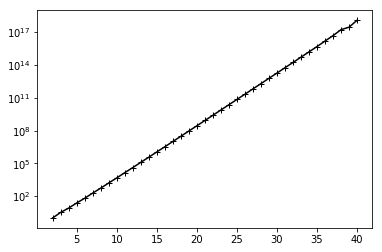

In [5]:
Nmax = 41;
N = np.arange(2,Nmax);
c = np.zeros(Nmax-2);
for n in N:
    x = np.linspace(-1,1,n);
    V = np.vander(x,increasing="True");
    c[n-2] = np.linalg.cond(V);

pl.semilogy(N,c,'k-+');

A better way to go about interpolating with polynomials is via Lagrange interpolation. Define the Lagrange polynomial $L_i(x)$ to be $1$ when $x=x_i$ and is zero at all the other nodes, i.e.,
$$L_i\bkt{x_j} = \delta_{ij}$$
We then have
$$p_n(x) = \sum_{i=0}^n f_i L_i(x)$$
Since we want $L_i(x)$ to vanish at all $x_j$, where $j \neq i$, we have $L_i(x) = c_i \prod_{j \neq i}\bkt{x-x_j}$. Further, since $L_i\bkt{x_i} = 1$, we get that $c = \dfrac1{\prod_{j \neq i} \bkt{x_i-x_j}}$. Hence, we see that
$$L_i\bkt{x} = \prod_{j \neq i} \bkt{\dfrac{x-x_j}{x_i-x_j}}$$
If we call $l_i(x) = \prod_{j \neq i} \bkt{x-x_j}$ and $w_i = \prod_{j \neq i} \bkt{\dfrac1{x_i-x_j}}$, we see that $L_i(x) = w_i l_i(x)$.

Further, if we set $l(x) = \prod_{j=0}^n \bkt{x-x_j}$, we see that $l_i(x) = \dfrac{l(x)}{x-x_i}$, and hence $L_i(x) = \dfrac{w_il(x)}{x-x_i}$ and hence we see that
\begin{align}
p_n(x) = l(x) \bkt{\sum_{i=0}^n \dfrac{w_i f_i}{x-x_i}} \,\,\, \spade
\end{align}
Note that $\spade$ is an attractive way to compute the Lagrange interpolant. It requires $\mathcal{O}\bkt{n^2}$ work to calculate $w_i$'s, followed by $\mathcal{O}(n)$ work to compute the interpolant for each $x$. This is called as the ***first form of Barycentric interpolation***.

What about updating when a new interpolation node $x_{n+1}$ is added? There are only two steps involved.

- For $i \in\{0,1,\ldots,n\}$, divide each $w_i$ by $\bkt{x_i-x_{n+1}}$. Cost is $n+1$ flops.
- Compute $w_{n+1}$ for another $n+1$ flops.

Hence, we see that the Lagrange interpolant can also be updated at $\mathcal{O}(n)$ flops.

The above barycentric formula can be made even more elegant in practice. Note that the function $1$ gets interpolated by any polynomial exactly. Hence, we see that
$$1 = l(x) \bkt{\sum_{i=0}^n \dfrac{w_i}{x-x_i}}$$
which gives us that
$$l(x) = \dfrac1{\bkt{\displaystyle\sum_{i=0}^n \dfrac{w_i}{x-x_i}}}$$
Hence, we obtain the ***second form of Barycentric interpolation***
\begin{align}
p_n(x) = \dfrac{\bkt{\displaystyle\sum_{i=0}^n \dfrac{w_i f_i}{x-x_i}}}{\bkt{\displaystyle\sum_{i=0}^n \dfrac{w_i}{x-x_i}}} \,\,\, \club
\end{align}
Again note that it is fairly easy to incorporate a new intepolation node at a cost of $\mathcal{O}(n)$. Below is the Lagrange interpolation using the original form.

0.09469417922518131


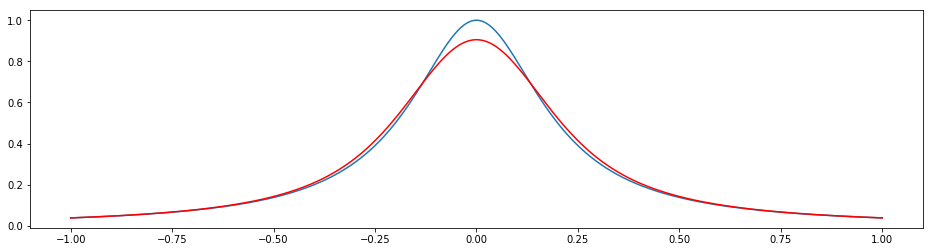

In [47]:
def function(x):
#     f = np.abs(x)+x/2-x**2;
    f = 1.0/(1+25*x*x);
#     f = np.abs(x+0.3) + np.abs(x-0.2) +  + np.abs(x*x*x*x-0.8);
    return f;

def Lagrange(xnodes,x,i):
    f = 1;
    nnodes = np.size(xnodes);
    for j in range(0,i):
        f = f*(x-xnodes[j])/(xnodes[i]-xnodes[j]);
    for j in range(i+1,nnodes):
        f = f*(x-xnodes[j])/(xnodes[i]-xnodes[j]);
    return f;
    
def Chebyshev(nnodes,xplot):
    # Chebyshev node interpolation
    xnodes    = np.cos(np.arange(0,nnodes)*np.pi/(nnodes-1));
    fnodes     = function(xnodes);
    fplot        = 0;
    for i in range(0,nnodes):
        fplot = fplot + fnodes[i]*Lagrange(xnodes,xplot,i);
    return xnodes, fnodes, fplot;

def Uniform(nnodes,xplot):
    # Uniform node interpolation
    xnodes    = np.linspace(-1,1,nnodes);
    fnodes     = function(xnodes);
    fplot        = 0;
    for i in range(0,nnodes):
        fplot = fplot + fnodes[i]*Lagrange(xnodes,xplot,i);
    return xnodes, fnodes, fplot;

def Bernstein(n,xplot):
    xnodes = np.linspace(-1,1,nnodes);
    fnodes  = function(xnodes);
    fplot = 0;
    for i in range(0,nnodes):
        fplot = fplot + sp.stats.binom.pmf(i,nnodes-1,0.5+0.5*xplot)*function(xnodes[i]);
    return fplot;
        
nplot       = 1001;
xplot       = np.linspace(-1,1,nplot);
f_actual   = function(xplot);
nnodes    = 201;
# xnodes, fnodes, fplot = Chebyshev(nnodes,xplot);
# xnodes, fnodes, fplot = Uniform(nnodes,xplot);
fplot        = Bernstein(nnodes,xplot);

error       = f_actual-fplot;
print(np.amax(np.abs(error)))
pl.plot(xplot,f_actual,'-');
pl.plot(xplot,fplot,'r');
pl.rcParams["figure.figsize"] = [16,4];